# Autoencoders

![autoencoder](notebook_images/autoencoder.jpg)

### References:

Deconvolution and Checkerboard Artifacts - https://distill.pub/2016/deconv-checkerboard/https://distill.pub/2016/deconv-checkerboard/

Some of the code has been taken from https://www.pyimagesearch.com/2020/03/30/autoencoders-for-content-based-image-retrieval-with-keras-and-tensorflow/

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras

import math
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

import os

import cv2


2023-05-19 10:14:06.313805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 10:14:06.409629: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-19 10:14:06.412104: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-05-19 10:14:06.412112: I tensorflow/compiler/xla/stream

## Auxiliary functions

In [2]:
def show_preds_3(set1, set2, set3, count):
  columns = 6
  rows = int(count*3 / columns) + 1  
  plt.figure(figsize=(15, 2 * rows))
  for n in range(count):
      ax = plt.subplot(rows, columns, n*3+1)
      plt.title("original")
      plt.imshow(set1[n], cmap=plt.get_cmap('gray'))
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*3+2)
      plt.title("reconst")
      plt.imshow(set2[n], cmap=plt.get_cmap('gray'))
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*3+3)
      plt.title("noisy")
      plt.imshow(set3[n], cmap=plt.get_cmap('gray'))
      plt.axis('off')

def show_preds(set1, set2, count):
  columns = 4
  rows = int(count*2 / columns) + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(count):
      ax = plt.subplot(rows, columns, n*2+1)
      plt.title("original")
      plt.imshow(set1[n], cmap=plt.get_cmap('gray'))
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*2+2)
      plt.title("reconstruction")
      plt.imshow(set2[n], cmap=plt.get_cmap('gray'))
      plt.axis('off')    
        
def plot_scatter(x,y,train_Y):
    cmap = colors.ListedColormap(['black', 'darkred', 'darkblue', 'darkgreen', 'yellow', 'brown', 'purple', 'lightgreen', 'red', 'lightblue'])
    bounds=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,8.5,9.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10,10))
    plt.scatter(x, y, c = train_Y, cmap=cmap, s = 1, norm=norm)
    plt.colorbar()

    plt.show()

    # assumes len samples is a perfect square
def show_samples(samples):
    
    k = int(math.sqrt(len(samples)))
    fig = plt.figure(figsize=(k,k))
    
    for i in range(len(samples)):
        plt.subplot(k, k, i+1)
        plt.imshow(np.asarray(samples)[i, :, :, 0], cmap='gray')
        plt.axis('off')    

def show_content_retrieval(train_X, top50):

    fig = plt.figure(figsize=(10,50))
    for i in range(len(top50)):
        ax = plt.subplot(25,5,i+1)
        plt.imshow(train_X[top50[i][1]], cmap='gray')
        plt.title(f'{top50[i][0]:.3f}')
        plt.axis('off')        


def load_and_prepare_image(file):


    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (28,28))

    dataImage = np.asarray(image).astype('float32') / 255.0
    dataImage = np.expand_dims(dataImage, axis=-1)
    dataImage = np.expand_dims(dataImage, axis=0)

    return dataImage



def show_pair(a,b):
    fig = plt.figure(figsize=(5, 10))
    ax = plt.subplot(1, 2, 1 )
    plt.imshow(a, cmap=plt.get_cmap('gray'))
    plt.axis('off')
    ax = plt.subplot(1, 2, 2 )
    plt.imshow(b, cmap=plt.get_cmap('gray'))
    plt.axis('off')    


def show_anomaly_sample(image, recon, err):
        plt.figure(figsize=(5,2))
        ax = plt.subplot(1,2,1)
        plt.imshow(image, cmap='gray')
        plt.title(str(err))
        ax = plt.subplot(1,2,2)
        plt.imshow(recon, cmap='gray')
        plt.axis('off')

## Configuration

In [23]:
HEIGHT = 28
WIDTH = 28
NUM_CHANNELS = 1
BATCH_SIZE = 32
LATENT_SPACE_DIM = 16

model_path = 'autoencoder_mnist'

train_online = False

### Load and prepare MNIST dataset

In [4]:
((train_X, train_Y), (test_X, test_Y)) = mnist.load_data()

# change shape to have each pixel in a separate dimension
train_X = np.expand_dims(train_X, axis=-1)
test_X = np.expand_dims(test_X, axis=-1)

# rescale inputs
train_X = train_X.astype("float32") / 255.0
test_X = test_X.astype("float32") / 255.0

print('Train shape: ',train_X.shape)
print('Test shape:  ', test_X.shape)

Train shape:  (60000, 28, 28, 1)
Test shape:   (10000, 28, 28, 1)


# Autoencoder for reconstruction

![reconstruction](notebook_images/autoencoder_reconstruction.jpg)

## Architecture

In [5]:
inputs = Input(shape=(WIDTH, HEIGHT, NUM_CHANNELS))

# Encoder
x = Conv2D(32,(3,3), strides = 2, padding='same')(inputs)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)

x = Conv2D(64,(3,3), strides = 2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)

volumeSize = x.shape
x = Flatten()(x)

latent = Dense(LATENT_SPACE_DIM, name='latent')(x)

encoder = Model(inputs, latent, name='decoder')
encoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                           

2023-05-19 10:14:07.957105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 10:14:07.957375: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lau/.local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:
2023-05-19 10:14:07.957444: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lau/.local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:
2023-05-19 10:14:07.957500: W tensorflow/compiler/xla/stream_executor/platform/

In [6]:
# decoder
latent_inputs = Input(shape=(LATENT_SPACE_DIM,))
y = Dense(np.prod(volumeSize[1:]))(latent_inputs)

y = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(y)

y = Conv2DTranspose(64, (3,3), strides=2, padding='same')(y)
y = LeakyReLU(alpha=0.2)(y)
y = BatchNormalization()(y)

y = Conv2DTranspose(32, (3,3), strides=2, padding='same')(y)
y = LeakyReLU(alpha=0.2)(y)
y = BatchNormalization()(y)

y = Conv2DTranspose(NUM_CHANNELS, (3,3), padding='same')(y)
outputs = Activation('sigmoid', name='decoder')(y)

decoder = Model(latent_inputs, outputs, name='encoder')
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                           

In [7]:
autoencoder = Model(inputs, decoder(encoder(inputs)))
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 decoder (Functional)        (None, 2)                 25474     
                                                                 
 encoder (Functional)        (None, 28, 28, 1)         65473     
                                                                 
Total params: 90,947
Trainable params: 90,563
Non-trainable params: 384
_________________________________________________________________


In [8]:
opt = Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

In [9]:
EPOCHS = 25

if train_online:
    history = autoencoder.fit(train_X, train_X, epochs=EPOCHS, batch_size=BATCH_SIZE) #input e output iguais por ser um autoencoder

In [10]:
if train_online:
    encoder.save(f'{model_path}/encoder{LATENT_SPACE_DIM}.h5')
    decoder.save(f'{model_path}/decoder{LATENT_SPACE_DIM}.h5')
    autoencoder.save(f'{model_path}/autoencoder{LATENT_SPACE_DIM}.h5')

In [24]:
encoder = load_model(f'{model_path}/encoder{LATENT_SPACE_DIM}.h5')
decoder = load_model(f'{model_path}/decoder{LATENT_SPACE_DIM}.h5')
autoencoder = load_model(f'{model_path}/autoencoder{LATENT_SPACE_DIM}.h5')

313/313 [==============================] - 2s 5ms/step


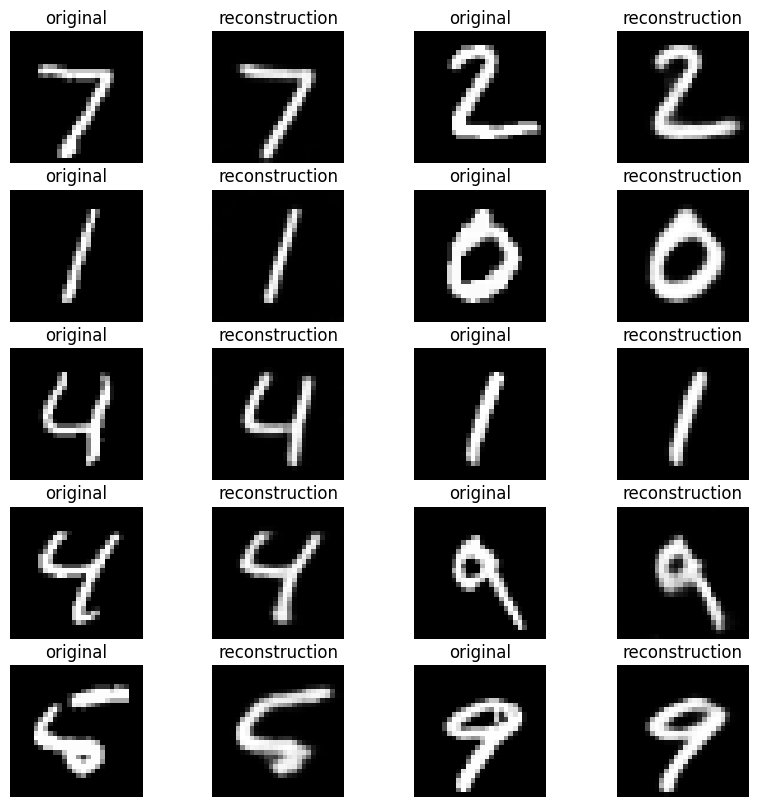

In [25]:
recon = autoencoder.predict(test_X)
show_preds(test_X,recon,10)

1875/1875 [==============================] - 2s 871us/step


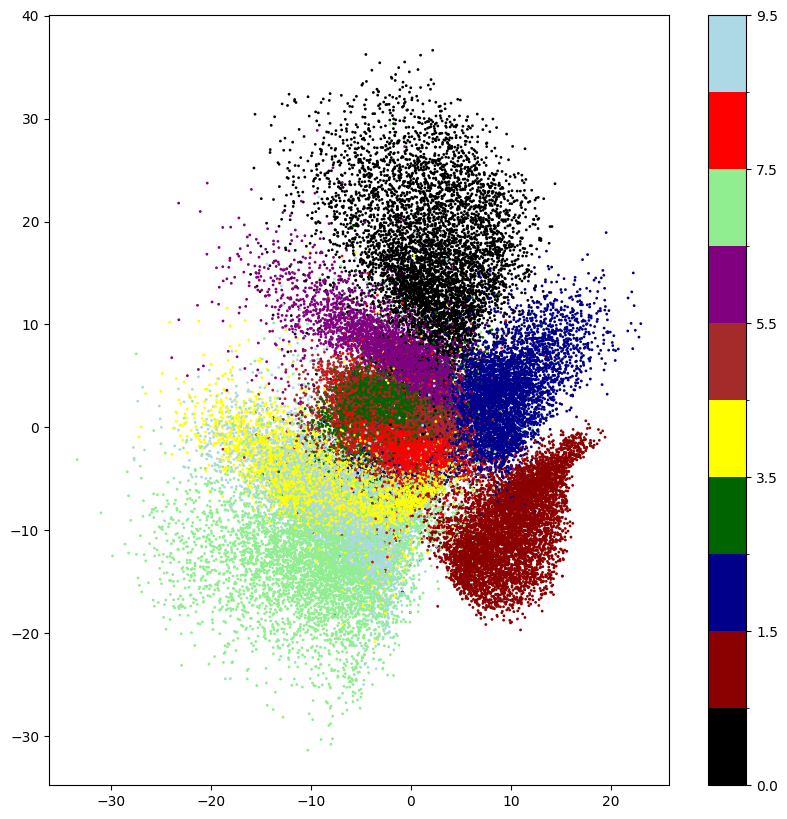

In [14]:
if LATENT_SPACE_DIM == 2:
    
    encoded = encoder.predict(train_X)
    
    x = np.array(encoded)[:,0]
    y = np.array(encoded)[:,1]
    
    plot_scatter(x,y, train_Y)

1/1 [==============================] - 0s 22ms/step


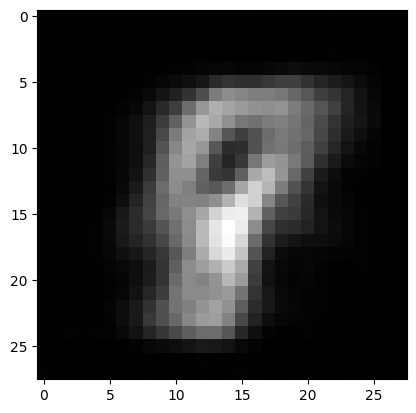

In [17]:
if LATENT_SPACE_DIM == 2:
    
    pred = decoder.predict([[0,-5]])
    plt.imshow(pred[0], cmap='gray')

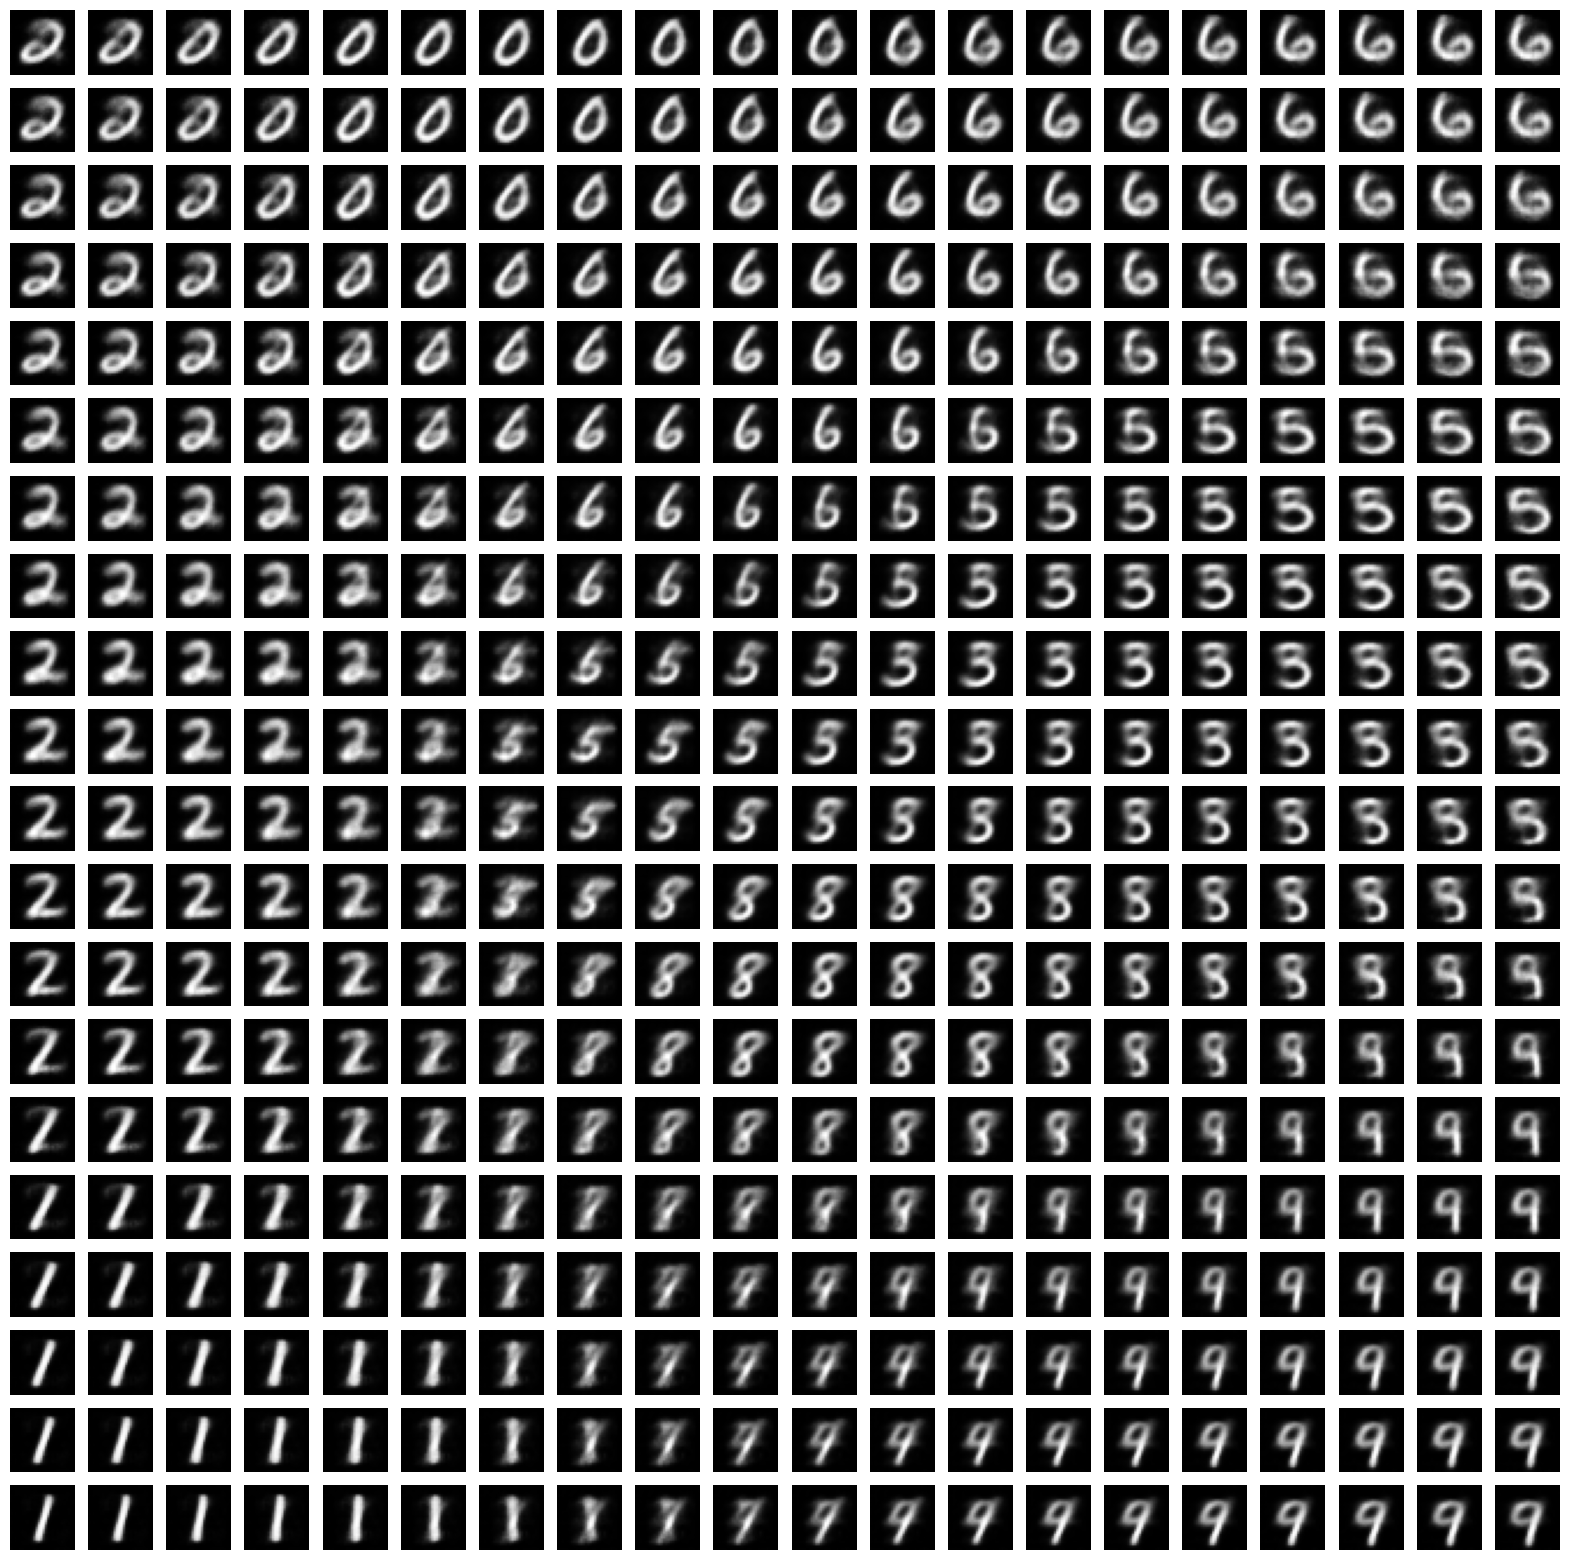

In [19]:
if LATENT_SPACE_DIM == 2:
    
    limit = 10
    steps = 20
    
    step = (2.0 * limit) / steps
    
    vector = [[limit - j * step, limit - i * step] for i in range(steps) for j in range(steps) ]
    predictions = decoder(np.asarray(vector))
    
    show_samples(predictions)

1/1 [==============================] - 0s 14ms/step


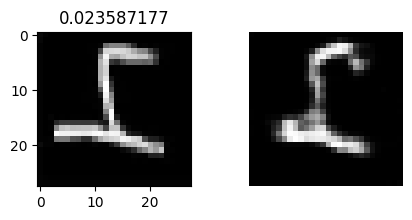

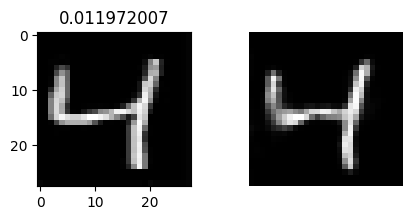

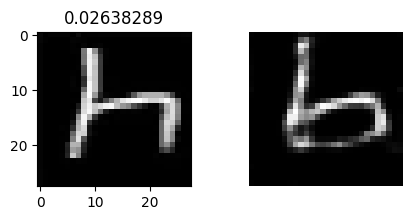

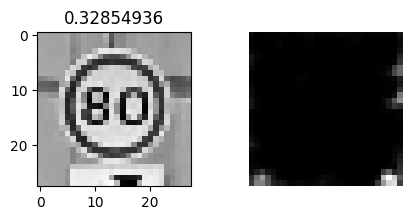

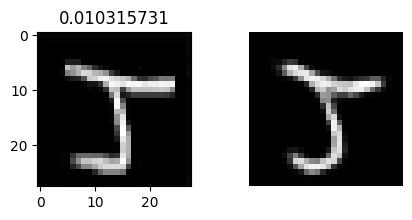

In [28]:
# detetar anomalias

def anomalyDetection(image_path):
    
    files = os.listdir(image_path)
    for f in files:
        data = load_and_prepare_image(os.path.join(image_path, f))
        
        testing = autoencoder.predict([data])
        err = np.mean((data - testing) ** 2)
        
        show_anomaly_sample(data[0], testing.squeeze(), err)
        
image_path = 'test_images/anomalyDetectionImages'
anomalyDetection(image_path)

In [29]:
features = encoder.predict(train_X)

1875/1875 [==============================] - 2s 880us/step


In [30]:
indexes = list(range(0, train_X.shape[0]))
data = {'indexes': indexes, 'features': features}

In [43]:
image_path = 'test_images/contentRetrievalImages/'

dataImage = load_and_prepare_image(os.path.join(image_path, '2.jpg'))

In [44]:
dataLatent = encoder.predict(dataImage).squeeze()

1/1 [==============================] - 0s 15ms/step


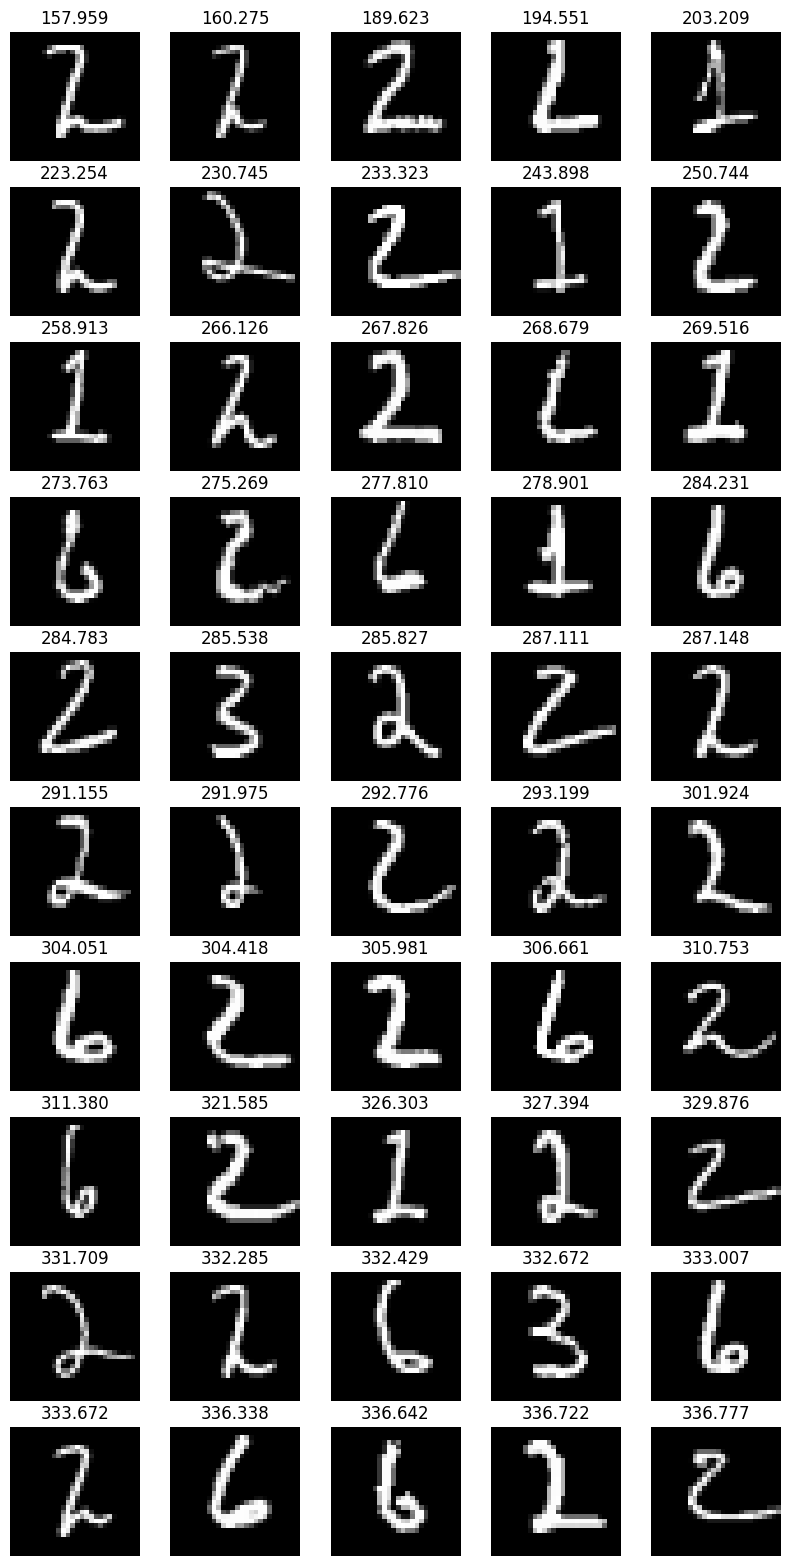

In [45]:
results = []
for i in range(len(data['indexes'])):
    err = np.sum((dataLatent - data['features'][i]) ** 2)
    err /= float(dataLatent.shape[0])
    results.append([err,i])
    
top50 = sorted(results)[:50]

show_content_retrieval(train_X, top50)

## Denoiser

In [46]:
noisyTrain = train_X.copy()
noisyTest = test_X.copy()

In [48]:
prob = 0.1

for i in range(len(noisyTrain)):
    probs = np.random.random(noisyTrain.shape[1:])
    noisyTrain[i][probs < (probs/2)] = 0
    noisyTrain[i][probs > 1 - prob/2] = 1
    
for i in range(len(noisyTest)):
    probs = np.random.random(noisyTest.shape[1:])
    noisyTest[i][probs < (probs/2)] = 0
    noisyTest[i][probs > 1 - prob/2] = 1

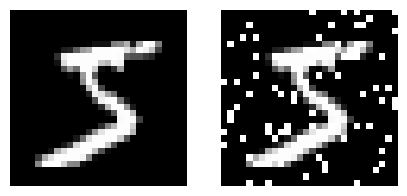

In [49]:
show_pair(train_X[0], noisyTrain[0])

In [51]:
if train_online:
    hist = autoencoder.fit(noisyTrain, train_X, epochs=EPOCHS, batch_size=BATCH_SIZE)
    autoencoder.save(f'{model_path}/autoencoder_{LATENT_SPACE_DIM}_denoise.h5')

In [52]:
autoencoder = load_model(f'{model_path}/autoencoder_{LATENT_SPACE_DIM}_denoise.h5')

313/313 [==============================] - 2s 5ms/step


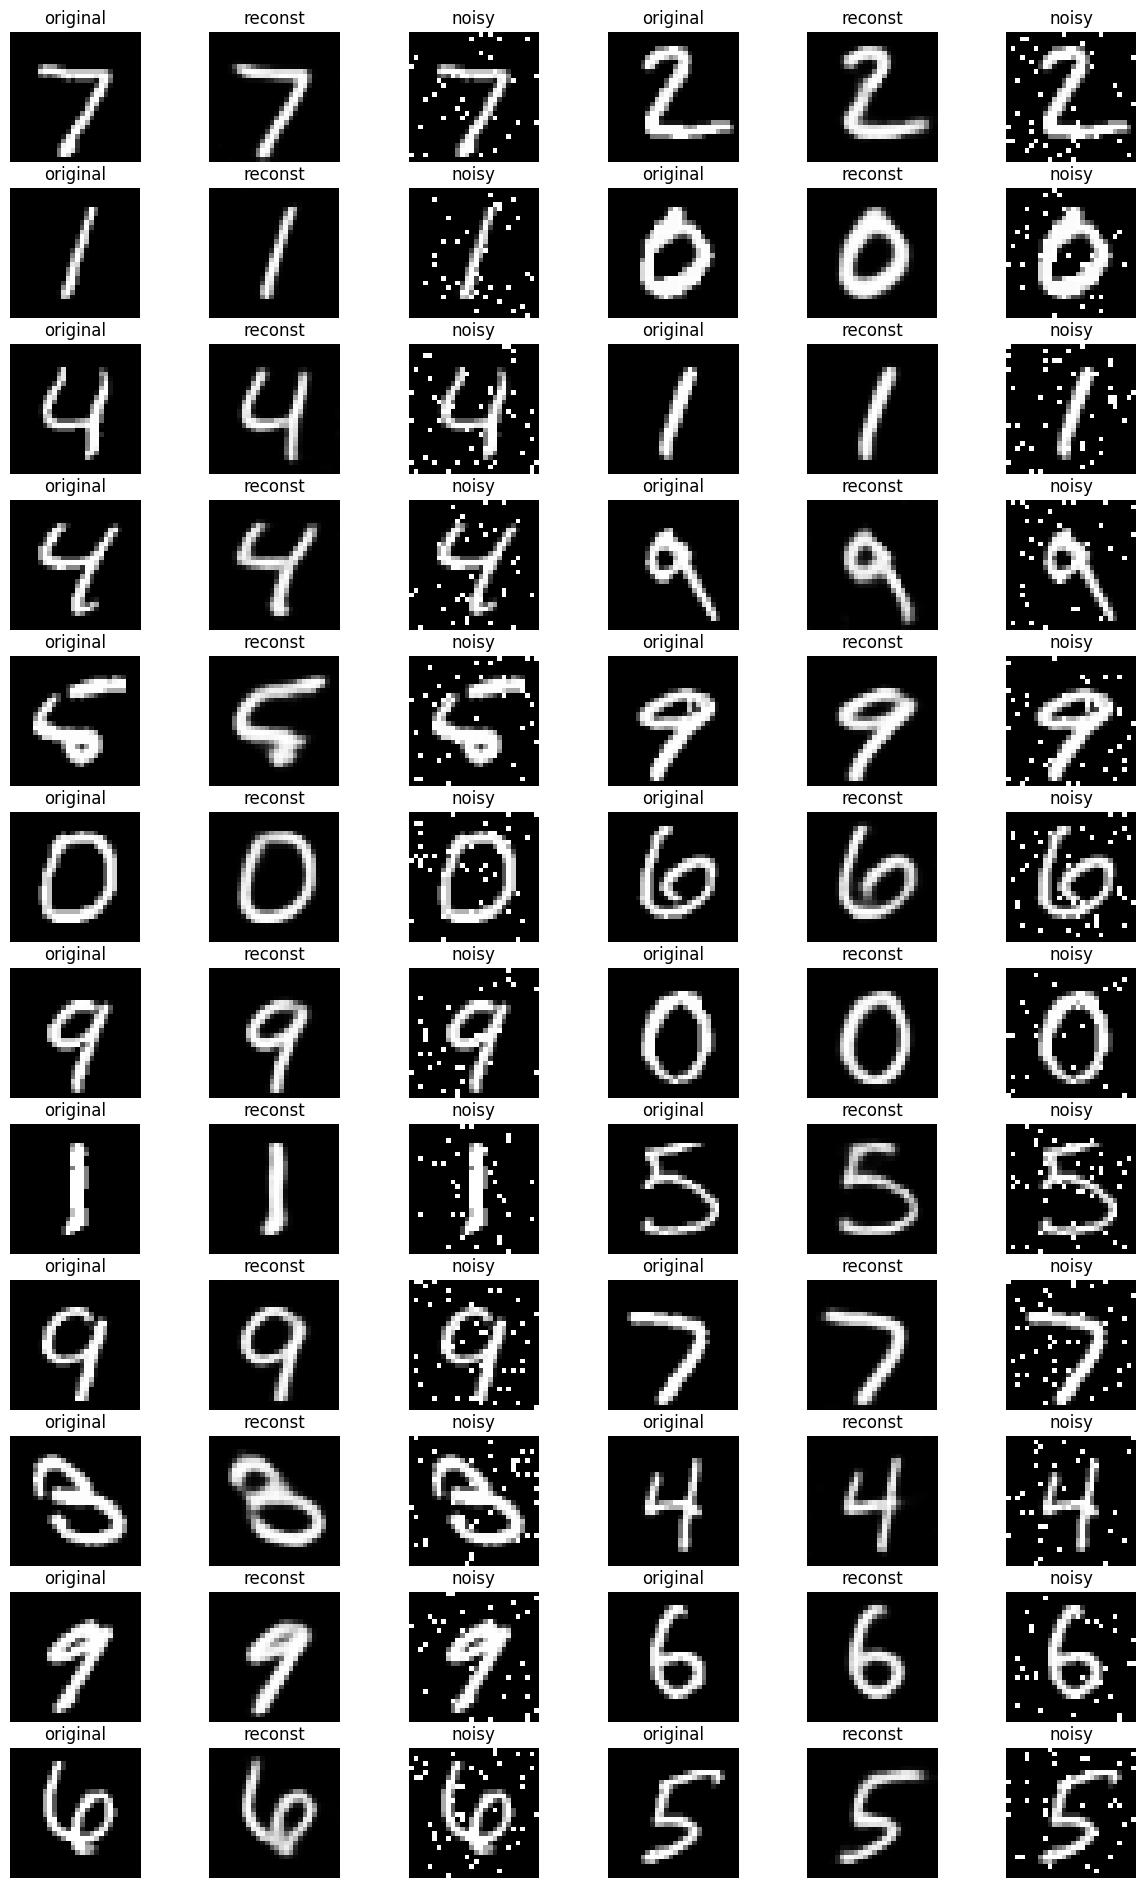

In [54]:
recon = autoencoder.predict(noisyTest)
show_preds_3(test_X, recon, noisyTest,24)